# Data over time


Trying to get a better understanding of the accumulation of evidence over time.


In [1]:
%%bash
datasets=("study" "credible_set" "l2g_prediction" "target")
for dataset in "${datasets[@]}"
    do mkdir -p ../../tmp/"${dataset}"
    # Copy the data from Google Cloud Storage to the local tmp directory
    gsutil -m rsync -r gs://open-targets-data-releases/25.06/output/${dataset} ../../tmp/${dataset}
done

mkdir -p ../../tmp/variant-effect-prediction
gsutil -m rsync -r gs://genetics-portal-dev-analysis/ss60/gentropy-manuscript/chapters/variant-effect-prediction ../../tmp/variant-effect-prediction



both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Starting synchronization...
If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that 

CalledProcessError: Command 'b'datasets=("study" "credible_set" "l2g_prediction" "target")\nfor dataset in "${datasets[@]}"\n    do mkdir -p ../../tmp/"${dataset}"\n    # Copy the data from Google Cloud Storage to the local tmp directory\n    gsutil -m rsync -r gs://open-targets-data-releases/25.06/output/${dataset} ../../tmp/${dataset}\ndone\n\nmkdir -p ../../tmp/variant-effect-prediction\ngsutil -m rsync -r gs://genetics-portal-dev-analysis/ss60/gentropy-manuscript/chapters/variant-effect-prediction ../../tmp/variant-effect-prediction\n'' returned non-zero exit status 1.

In [2]:
from pathlib import Path

import pyspark.sql.functions as f
from pyspark.sql import SparkSession

# Starting a Spark session
spark = (
    SparkSession.builder.appName("Overtime")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)


25/06/25 14:50:34 WARN Utils: Your hostname, C02YN2L7JHD2 resolves to a loopback address: 127.0.0.1; using 172.23.49.165 instead (on interface en0)
25/06/25 14:50:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/25 14:50:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
%load_ext rpy2.ipython


In [5]:
%%R
packages <- c("cowplot", "ggplot2", "dplyr", "forcats", "viridis")
for (package in packages) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package, repos = "http://cran.us.r-project.org")
  }
  library(package, character.only = TRUE)
}


In [6]:
# Reading datasets
credible_set = spark.read.parquet(
    str(Path.cwd().joinpath("../../tmp/credible_set").resolve())
)
l2g_prediction = spark.read.parquet(
    str(Path.cwd().joinpath("../../tmp/l2g_prediction").resolve())
)
study = spark.read.parquet(str(Path.cwd().joinpath("../../tmp/study").resolve()))
target = spark.read.parquet(str(Path.cwd().joinpath("../../tmp/target").resolve()))
rescaledBetas = spark.read.parquet(
    str(Path.cwd().joinpath("../../tmp/variant-effect-prediction/").resolve())
)


In [7]:
gwas_publication_by_year = (
    study.filter(f.col("studyType") == "gwas")
    .filter(f.col("publicationDate").isNotNull())
    .groupBy("pubmedId")
    .agg(
        f.first("publicationDate").alias("publicationDate"),
        f.first("hasSumstats").alias("hasSumstats"),
    )
    .withColumn("hasSumstats", f.coalesce(f.col("hasSumstats"), f.lit(False)))
)
pd_gwas_publication_by_year = gwas_publication_by_year.toPandas()


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 61 rows containing non-finite values (`stat_count()`). 

R[write to console]: 2: Removed 3 rows containing missing values (`geom_bar()`). 



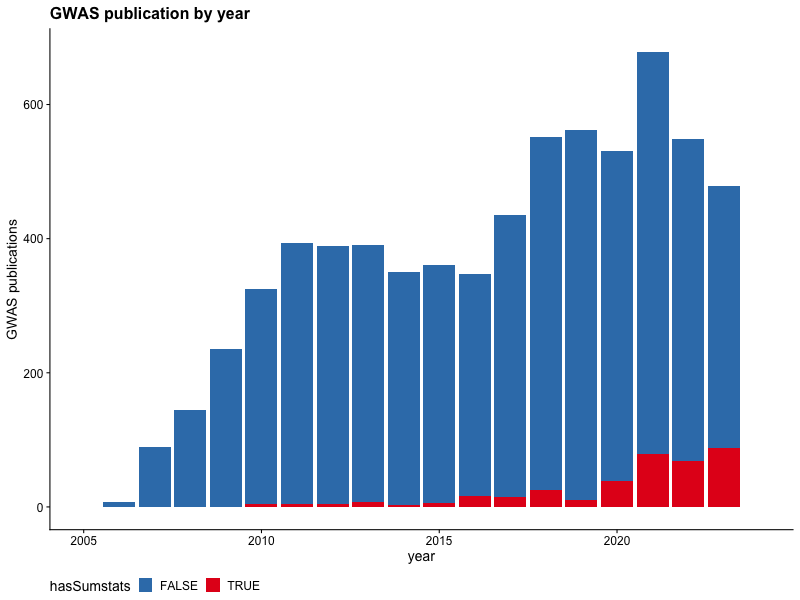

In [8]:
%%R -i pd_gwas_publication_by_year -w 800 -h 600
p_gwas_publication_by_year <- pd_gwas_publication_by_year %>%
    mutate(year = as.integer(format(as.Date(publicationDate), "%Y"))) %>%
    ggplot(aes(x = year, fill = hasSumstats)) +
    geom_bar(stat = "count") +
    theme_cowplot() +
    xlim(2005, 2024) +
    scale_y_continuous(name = "GWAS publications") +
    scale_fill_brewer(palette = "Set1", direction = -1) +
    ggtitle("GWAS publication by year") +
    theme(legend.position = "bottom")
p_gwas_publication_by_year


In [9]:
from pyspark.sql import Window

w = Window.orderBy("year").rangeBetween(-1, 1)
gwas_study_sample_size_year = (
    study.filter(f.col("studyType") == "gwas")
    .filter(f.col("publicationDate").isNotNull())
    # sample size by pubmed (not by study)
    .groupBy("pubmedId", "publicationDate")
    .agg(
        f.mean("nSamples").alias("mean_pmid_nSamples"),
    )
    .select(
        "mean_pmid_nSamples",
        f.year(f.to_date("publicationDate", "yyyy-MM-dd")).alias("year"),
    )
    .withColumn(
        "stats",
        f.approx_percentile("mean_pmid_nSamples", [0.25, 0.5, 0.75], 1000).over(w),
    )
    .select(
        "year",
        f.col("stats").getItem(0).alias("q1"),
        f.col("stats").getItem(1).alias("q2"),
        f.col("stats").getItem(2).alias("q3"),
    )
    .distinct()
)

pd_gwas_study_sample_size_year = gwas_study_sample_size_year.toPandas()


25/06/25 14:50:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:50:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:50:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:50:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:50:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:50:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 1 rows containing missing values (`geom_pointrange()`). 



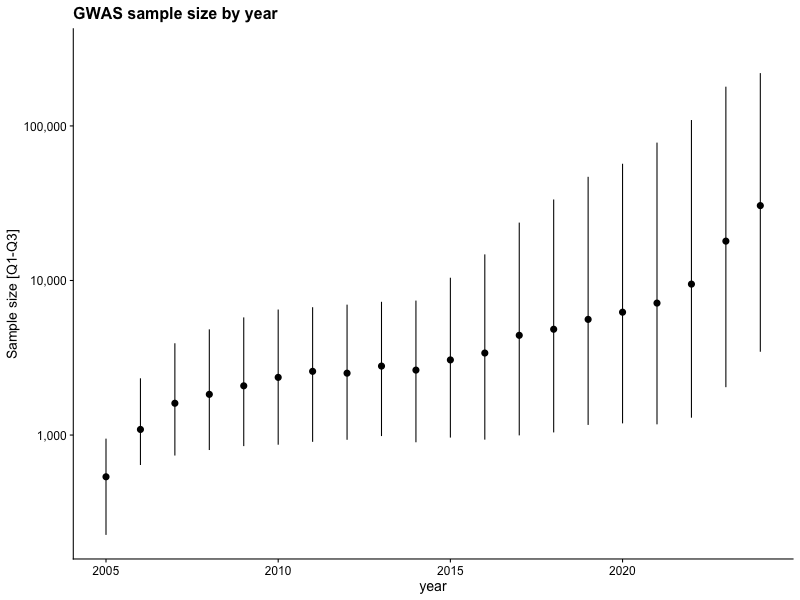

In [10]:
%%R -i pd_gwas_study_sample_size_year -w 800 -h 600
p_gwas_study_sample_size_year <- pd_gwas_study_sample_size_year %>%
    ggplot(aes(x = year, y = q2, ymin = q1, ymax = q3)) +
    geom_pointrange() +
    xlim(2005, 2024) +
    scale_y_log10(name = "Sample size [Q1-Q3]", labels = scales::comma) +
    theme_cowplot() +
    ggtitle("GWAS sample size by year")
p_gwas_study_sample_size_year


In [11]:
w = Window.orderBy("year").rangeBetween(-2, 2)
gwas_study_mean_effects_year = (
    rescaledBetas.filter(f.col("studyType") == "gwas")
    .filter(f.col("publicationDate").isNotNull())
    .groupBy("pubmedId", "publicationDate")
    .agg(
        f.mean(f.abs("rescaledStatistics.estimatedBeta")).alias(
            "mean_pmid_estimatedBeta"
        )
    )
    .select(
        "mean_pmid_estimatedBeta",
        f.year(f.to_date("publicationDate", "yyyy-MM-dd")).alias("year"),
    )
    .withColumn(
        "stats",
        f.approx_percentile("mean_pmid_estimatedBeta", [0.25, 0.5, 0.75], 1000).over(w),
    )
    .select(
        "year",
        f.col("stats").getItem(0).alias("q1"),
        f.col("stats").getItem(1).alias("q2"),
        f.col("stats").getItem(2).alias("q3"),
    )
    .distinct()
)

pd_gwas_study_mean_effects_year = gwas_study_mean_effects_year.toPandas()


25/06/25 14:51:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:51:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:51:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:51:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:51:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/25 14:51:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


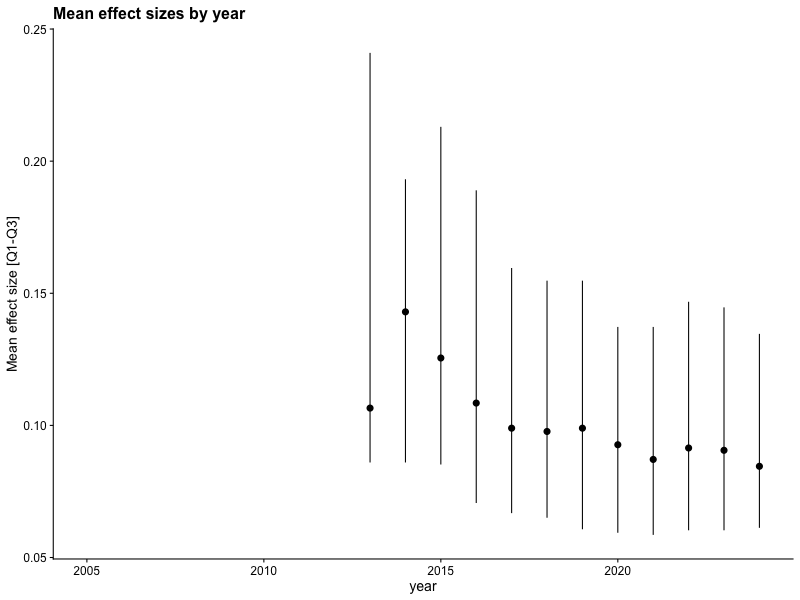

In [12]:
%%R -i pd_gwas_study_mean_effects_year -w 800 -h 600
p_gwas_study_mean_effects_year <- pd_gwas_study_mean_effects_year %>%
    ggplot(aes(x = year, y = q2, ymin = q1, ymax = q3)) +
    geom_pointrange() +
    xlim(2005, 2024) +
    scale_y_continuous(name = "Mean effect size [Q1-Q3]", labels = scales::comma) +
    theme_cowplot() +
    ggtitle("Mean effect sizes by year")
p_gwas_study_mean_effects_year


In [13]:
from pyspark.sql import Window

w_bin = (
    Window.partitionBy("geneId")
    .orderBy(f.desc("l2g_bin"))
    .rangeBetween(Window.unboundedPreceding, 0)
)
w_cumsum = (
    Window.partitionBy("l2g_bin")
    .orderBy("year")
    .rangeBetween(Window.unboundedPreceding, 0)
)
w_correction = Window.partitionBy("year").orderBy(f.desc("l2g_bin"))

gene_earliest_publication_date = (
    l2g_prediction.select("studyLocusId", "geneId", "score")
    .join(
        credible_set.select("studyLocusId", "studyId"), on="studyLocusId", how="inner"
    )
    .join(
        study.select(
            "studyId",
            f.to_date("publicationDate", "yyyy-MM-dd").alias("publicationDate"),
        ),
        on="studyId",
        how="inner",
    )
    # Calculate the earliest publication date for each geneId
    .withColumn(
        "l2g_bin",
        f.when(f.col("score") >= 0.75, f.lit(0.75))
        .when(f.col("score") >= 0.5, f.lit(0.5))
        .when(f.col("score") >= 0.25, f.lit(0.25))
        .otherwise(f.lit(0.05)),
    )
    .groupBy("geneId", "l2g_bin")
    .agg(f.min("publicationDate").alias("earliestPublicationDate"))
    # Account for >0.5 being included in >0.05
    .withColumn(
        "adjustedEarliestPublicationDate", f.min("earliestPublicationDate").over(w_bin)
    )
    .withColumn("year", f.year("adjustedEarliestPublicationDate"))
    # Represent gene in all posterior years
    .withColumn("years", f.sequence("year", f.lit(2024)))
    .select("geneId", "l2g_bin", f.explode("years").alias("year"))
    # Count the number of genes per bin and year (cumulative)
    .groupBy("l2g_bin", "year")
    .agg(f.countDistinct("geneId").alias("cumsum"))
    # Represent a gene exclusively in groups instead of in all of them
    .withColumn(
        "cumsum_correction",
        f.col("cumsum") - f.coalesce(f.lag("cumsum").over(w_correction), f.lit(0)),
    )
)
pd_gene_earliest_publication_date = gene_earliest_publication_date.toPandas()


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


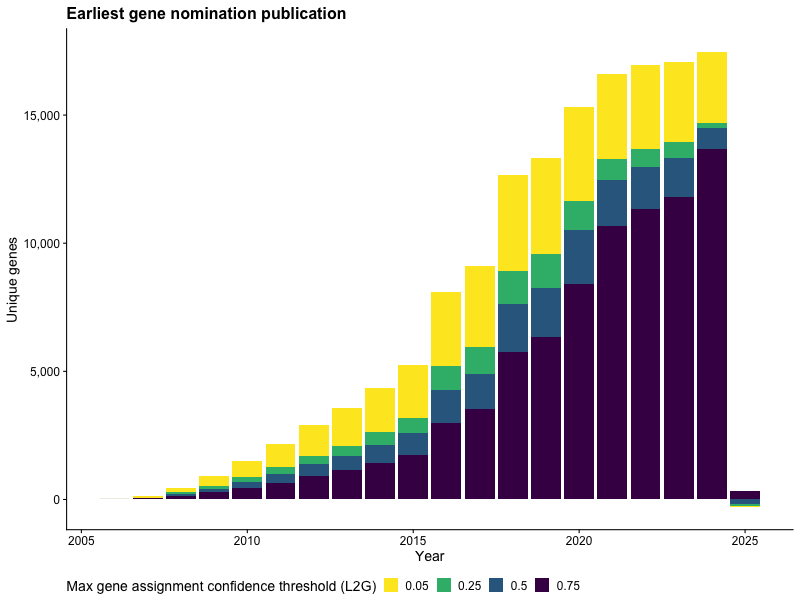

In [14]:
%%R -i pd_gene_earliest_publication_date -w 800 -h 600
p_gene_earliest_publication_date <- pd_gene_earliest_publication_date %>%
    ggplot(aes(x = year, y =  cumsum_correction, fill=as_factor(l2g_bin))) +
    geom_bar(stat = "identity") +
    theme_cowplot() +
    scale_y_continuous(labels = scales::comma) +
    scale_fill_viridis(discrete = TRUE, direction = -1, name = "Max gene assignment confidence threshold (L2G)") +
    scale_y_continuous(name = "Unique genes", labels = scales::comma) +
    scale_x_continuous(name = "Year") +
    ggtitle("Earliest gene nomination publication") +
    theme(legend.position = "bottom")
p_gene_earliest_publication_date


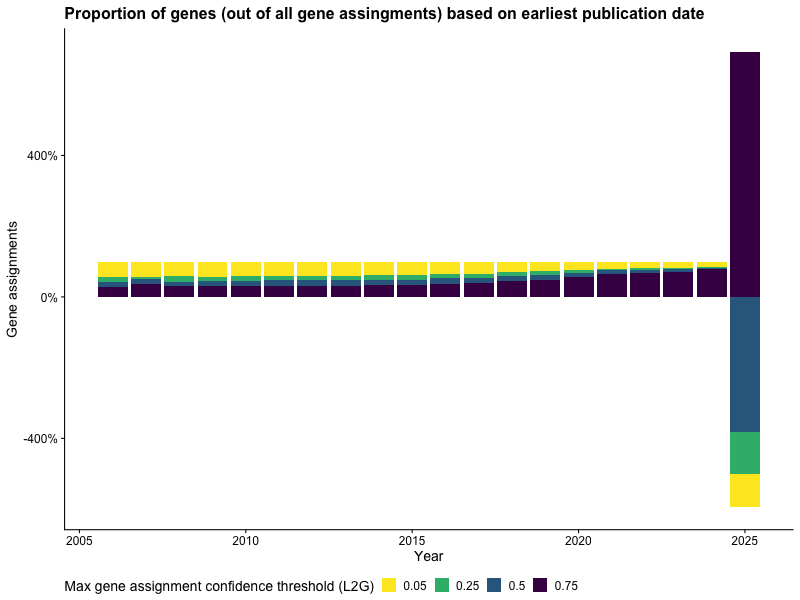

In [15]:
%%R -i pd_gene_earliest_publication_date -w 800 -h 600
p_gene_earliest_publication_date_stacked <- pd_gene_earliest_publication_date %>%
    group_by(year) %>%
    mutate(totalyear = sum(cumsum_correction)) %>%
    ggplot(aes(x = year, y =  cumsum_correction / totalyear, fill=as_factor(l2g_bin))) +
    geom_bar(stat = "identity") +
    theme_cowplot() +
    scale_fill_viridis(discrete = TRUE, direction = -1, name = "Max gene assignment confidence threshold (L2G)") +
    scale_y_continuous(name = "Gene assignments", labels = scales::percent) +
    scale_x_continuous(name = "Year") +
    ggtitle("Proportion of genes (out of all gene assingments) based on earliest publication date") +
    theme(legend.position = "bottom")
    
p_gene_earliest_publication_date_stacked


In [16]:
%%R -w 400 -h 800
common_theme <- function() {
    theme(
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.length.x = unit(0, "pt"),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        legend.position = "bottom",
        legend.box = "horizontal",
        legend.box.just = "left",
        legend.key.size = unit(0.5, "cm"),
        legend.text = element_text(size = 8),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=1),
        plot.title = element_blank(),
        plot.margin = unit(c(0, 5.5,0,5.5), "pt"),
    )
}
timeframeStart <- 2005
timeframeEnd <- 2024
# Plotting all together
plot_grid(
    p_gwas_publication_by_year + common_theme() + theme(legend.position = "none"),
    p_gwas_study_sample_size_year + common_theme(),
    p_gwas_study_mean_effects_year + common_theme(),
    p_gene_earliest_publication_date + common_theme() + theme(legend.position = "none"),
    p_gene_earliest_publication_date_stacked + common_theme() + theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.ticks.x = element_line(), legend.position = "none", plot.margin = margin(b = unit(9, "pt")), axis.ticks.length.x = unit(3, "pt")),
    ncol=1,
    align="v"
)


TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

In [ ]:
%%R 
p_gene_earliest_publication_date
